## 1. Importing Libraries

In [1]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
import pandas as pd
import re, string, unicodedata
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from wordcloud import WordCloud, ImageColorGenerator
import seaborn as sns
from nltk.util import ngrams

plt.style.use('ggplot')

C:\Users\HPHP\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [18]:
pd.options.display.max_colwidth=200

## 2. Initializing SentimentIntensityAnalyzer

In [2]:
sentiment = SentimentIntensityAnalyzer()

In [20]:
def print_sentiment_scores(sentence):
    snt = sentiment.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(snt)))

## 3. Reading the data from CSV file

In [4]:
data = pd.read_csv('Tweets.csv')
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760000,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2/24/2015 11:35,NaN,Eastern Time (US & Canada)
1,570301130888122000,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2/24/2015 11:15,NaN,Pacific Time (US & Canada)
2,570301083672813000,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2/24/2015 11:15,Lets Play,Central Time (US & Canada)
3,570301031407624000,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2/24/2015 11:15,NaN,Pacific Time (US & Canada)
4,570300817074462000,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2/24/2015 11:14,NaN,Pacific Time (US & Canada)


In [5]:
data.shape

(14640, 15)

In [171]:
tweets = pd.DataFrame(data['text'][:1000])
tweets.head(10)

,text
0,@VirginAmerica What @dhepburn said.
1,@VirginAmerica plus you've added commercials to the experience... tacky.
2,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,@VirginAmerica and it's a really big bad thing about it
5,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA
6,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)"
7,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP"
8,"@virginamerica Well, I didn't…but NOW I DO! :-D"
9,"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me."


### Looks like there are lot of references to other twitter handles and hyperlinks. Let's remove these using regular expressions.

In [172]:
data['text'] = data['text'].apply(lambda x: ' '.join(re.sub("(@[A-Za-z0-9]+)|(\w+:\/\/\S+)"," ",x).split()))

In [174]:
data['text'].head(10) # Now the tweets are looking cleaner

0                                                                                                                  What said.
1                                                                   plus you've added commercials to the experience... tacky.
2                                                                    I didn't today... Must mean I need to take another trip!
3             it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
4                                                                                    and it's a really big bad thing about it
5    seriously would pay $30 a flight for seats that didn't have this playing. it's really the only bad thing about flying VA
6                                                            yes, nearly every time I fly VX this “ear worm” won’t go away :)
7                                                       Really missed a prime opportunity for Men Without Hats parody,

## We can not remove punctuation, because it removes emoticons as well. Emoticons play a role in deciding Polarity strength.

## 4. Applying Vader on a sample sentence

In [175]:
#Using the reviews, accessing the first row and specifying the compound measure. We are not running on all rows just yet.

print('polarity score-compound: ', sentiment.polarity_scores('It was a good experience :)')['compound'])

polarity score-compound:  0.7096


## 5. Creating "Compound Polarity Score" for each tweet

In [176]:
data['polarity_score'] = data['text'].apply(lambda x: sentiment.polarity_scores(str(x))['compound'])

In [177]:
data[['text','polarity_score']][0:5]

,text,polarity_score
0,What said.,0.0000
1,plus you've added commercials to the experience... tacky.,0.0000
2,I didn't today... Must mean I need to take another trip!,0.0000
3,"it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",-0.5984
4,and it's a really big bad thing about it,-0.5829


Let us add one more column that will store the sentiment in words for each column of reviews

## 6. Creating 2 new columns to store Vader's sentiment

In [178]:
data['sentiment']=''
data['polarity']=''

## 7. Binning the "Compound Polarity Score" into 5 sentiments

#### Intervals

- (-1, -0.5) : 1, V.Negative
- (-0.5, 0) : 2, Negative
- (0) : 3, Neutral
- (0, 0.5) : 4, Positive
- (0.5, 1) : 5, V.Positive

In [179]:
# Creating Sentiment labels with 5 classes
data.loc[(data.polarity_score<=1) & (data.polarity_score>=0.5),'sentiment']='V.Positive'
data.loc[(data.polarity_score<0.5) & (data.polarity_score>0),'sentiment']='Positive'
data.loc[(data.polarity_score==0),'sentiment']='Neutral'
data.loc[(data.polarity_score<0) & (data.polarity_score>=-0.5),'sentiment']='Negative'
data.loc[(data.polarity_score<-0.5) & (data.polarity_score>=-1),'sentiment']='V.Negative'

In [180]:
# Creating Polarity labels with 3 classes
data.loc[(data.polarity_score<=1) & (data.polarity_score>0),'polarity']='positive'
data.loc[(data.polarity_score==0),'polarity']='neutral'
data.loc[(data.polarity_score<0) & (data.polarity_score>=-1),'polarity']='negative'

## 8. Bar plot of Vader sentiments

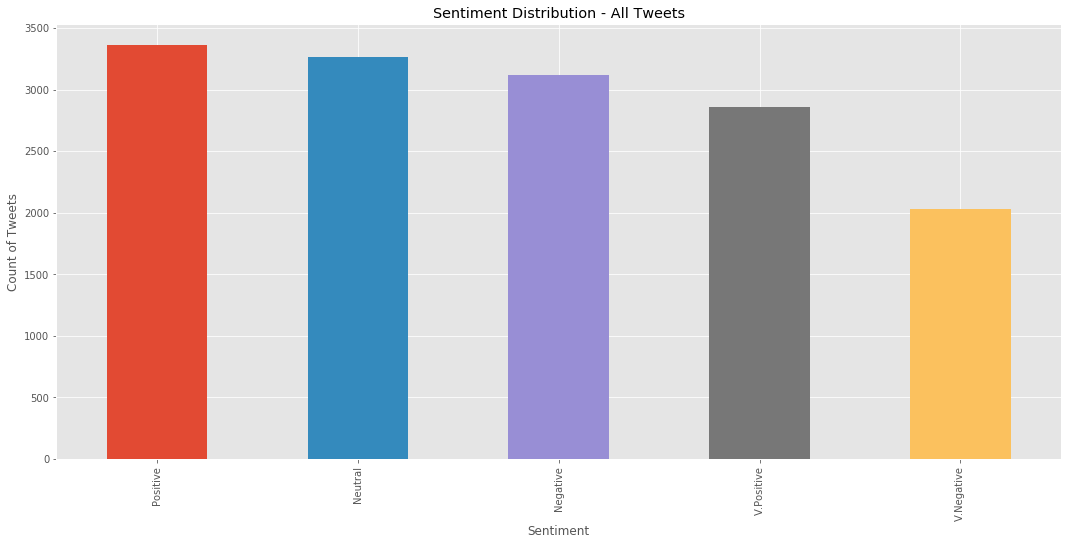

In [181]:
%matplotlib inline
plt.figure(figsize=(18,8))
plt.xlabel("Sentiment")
plt.ylabel("Count of Tweets")
data.sentiment.value_counts().plot(kind='bar', title="Sentiment Distribution - All Tweets")

## 9. Bar plot of Airline Sentiments

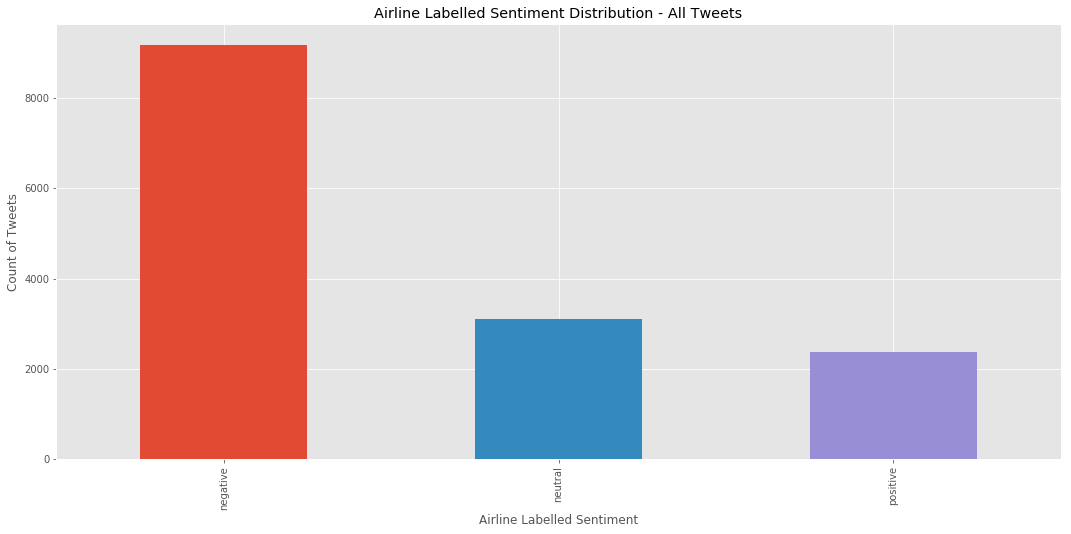

In [182]:
plt.figure(figsize=(18,8))
plt.xlabel("Airline Labelled Sentiment")
plt.ylabel("Count of Tweets")
data.airline_sentiment.value_counts().plot(kind='bar', title="Airline Labelled Sentiment Distribution - All Tweets")

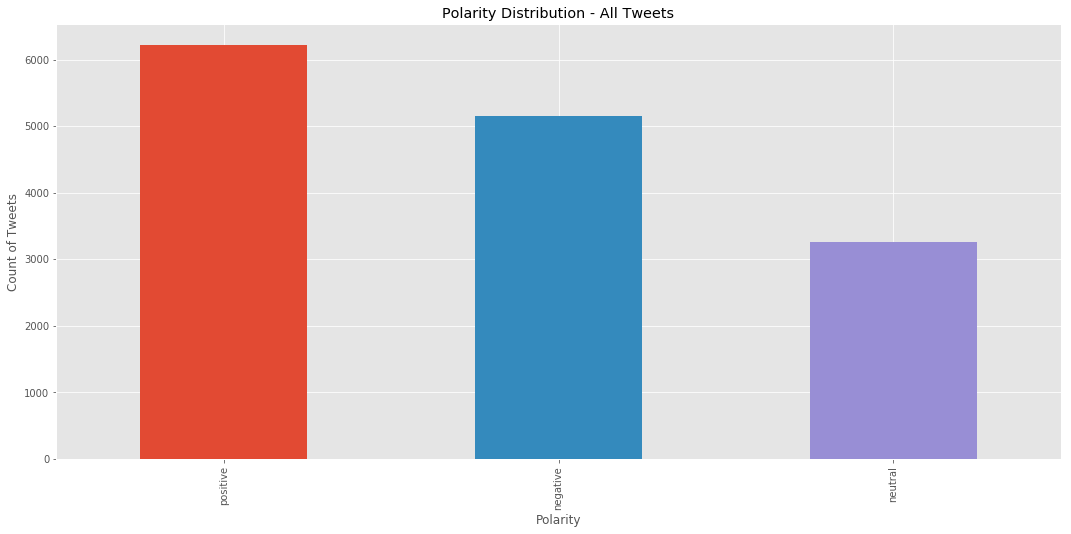

In [183]:
plt.figure(figsize=(18,8))
plt.xlabel("Polarity")
plt.ylabel("Count of Tweets")
data.polarity.value_counts().plot(kind='bar', title="Polarity Distribution - All Tweets")

### From above 2 plots, we can see the Vader analyzer labelled more tweets as positive compared to airline sentiments.

## 10. Accuracy of Vader's Sentiment compared to Airline labelled sentiments

In [184]:
#find accuracy
matched_sent = data[data['airline_sentiment'] == data['polarity']]

In [185]:
accuracy = (len(matched_sent)/data.shape[0])*100
print("The accuracy of Vader sentiment compared to airline  sentiments: " + str(accuracy))

The accuracy of Vader sentiment compared to airline  sentiments: 54.65846994535519


## Q1:

### WordCloud - Negative Tweets

### Removing stop words and unimportant words

In [186]:
# I came up with this list of custom words through an iterative process - Considered words which do not carry any information in this context
custom_stopwords_neg = list(stopwords.words('english'))
custom_stopwords_neg.extend(string.punctuation)
custom_stopwords_neg.extend(('americanair','usairways','united','southwestair','virginamerica','jetblue', 'http', 'co', 'i\'m', 'i', '\'m', 'amp', 'ca', 'wo', '\'s','n\'t', '\'ve', '\'\''))

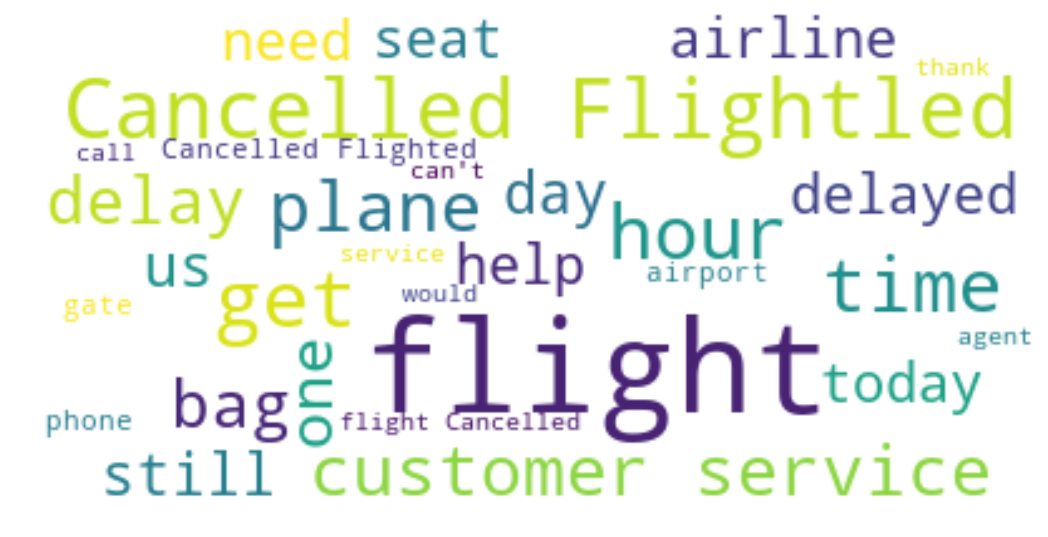

In [187]:
cloudstr = " ".join(tweet for tweet in data[data['polarity']=='negative']['text'])
wordcloud = WordCloud(background_color = "white", max_words=30, stopwords=custom_stopwords_neg).generate(cloudstr)

plt.figure(figsize=(18,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

## Customers were mostly talking about the above topics like "Cancelled Flight", "Delay", "Customer Service", "time" and so on when they tweeted negatively. The most frequent words used can also be seen below.

In [188]:
wordcloud.words_

{'flight': 1.0,
 'Cancelled Flightled': 0.30813475760065734,
 'get': 0.2933442892358258,
 'time': 0.25554642563681185,
 'hour': 0.25472473294987674,
 'customer service': 0.2456861133935908,
 'plane': 0.24404272801972063,
 'bag': 0.21281840591618734,
 'delay': 0.20788824979457682,
 'one': 0.1972062448644207,
 'day': 0.17337715694330322,
 'us': 0.16926869350862778,
 'still': 0.1676253081347576,
 'delayed': 0.15940838126540674,
 'help': 0.1561216105176664,
 'airline': 0.15283483976992604,
 'today': 0.15283483976992604,
 'need': 0.14790468364831552,
 'seat': 0.14461791290057519,
 'Cancelled Flighted': 0.142974527526705,
 'gate': 0.14050944946589974,
 'phone': 0.13393590797041907,
 'airport': 0.1322925225965489,
 'flight Cancelled': 0.1265406737880033,
 "can't": 0.11832374691865243,
 'call': 0.11832374691865243,
 'service': 0.11668036154478226,
 'would': 0.11585866885784717,
 'agent': 0.11585866885784717,
 'thank': 0.114215283483977}

## But the single word frequency doesn't give much info about the topics. Let's print the most frequent bi-grams.

### Sentence tokenizing all tweets

In [189]:
neg_sentences = []
neg_df = data[data['polarity']=='negative']
for i in range(0, neg_df.shape[0]):
    neg_sentences.extend(tweet for tweet in sent_tokenize(neg_df.iloc[i]['text']))
neg_sentences[:5]

['it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
 "and it's a really big bad thing about it",
 "seriously would pay $30 a flight for seats that didn't have this playing.",
 "it's really the only bad thing about flying VA",
 "Well, I didn't…but NOW I DO!"]

### Word tokenizing each of the sentecnes & extracting bi-grams

In [190]:
bigram_neg = []
for line in neg_sentences:
    tokens = (word for word in word_tokenize(line) if word.lower() not in custom_stopwords_neg)
    bigram_neg.extend(ngrams(tokens, 2))

C:\Users\HPHP\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: generator 'ngrams' raised StopIteration
  after removing the cwd from sys.path.


In [191]:
fdist_neg = nltk.FreqDist(bigram_neg)
fdist_neg.most_common(20)

[(('Cancelled', 'Flightled'), 369),
 (('customer', 'service'), 269),
 (('Cancelled', 'Flighted'), 168),
 (('Late', 'Flight'), 124),
 (('flight', 'Cancelled'), 118),
 (('Cancelled', 'Flight'), 102),
 (('Booking', 'Problems'), 100),
 (('Flightled', 'flight'), 69),
 (('Late', 'Flightr'), 67),
 (('Flight', 'Booking'), 65),
 (('flight', 'delayed'), 60),
 (('2', 'hours'), 49),
 (('call', 'back'), 45),
 (('hour', 'delay'), 42),
 (('delayed', 'flight'), 36),
 (('Flighted', 'flight'), 36),
 (('trying', 'get'), 35),
 (('Flight', 'flight'), 35),
 (('3', 'hours'), 34),
 (('get', 'home'), 34)]

## We can see that above 2-word phrases occurred most frequently in "Negative tweets".

## Q2:

### WordCloud - Positive Tweets

In [192]:
custom_stopwords_pos = list(stopwords.words('english'))
custom_stopwords_pos.extend(string.punctuation)
custom_stopwords_pos.extend(('americanair','usairways','united','southwestair','virginamerica','jetblue', 'http', 'co', 'i\'m', 'i', '\'m', 'amp', 'ca', 'wo', '\'s','n\'t', '\'ve', '\'\''))

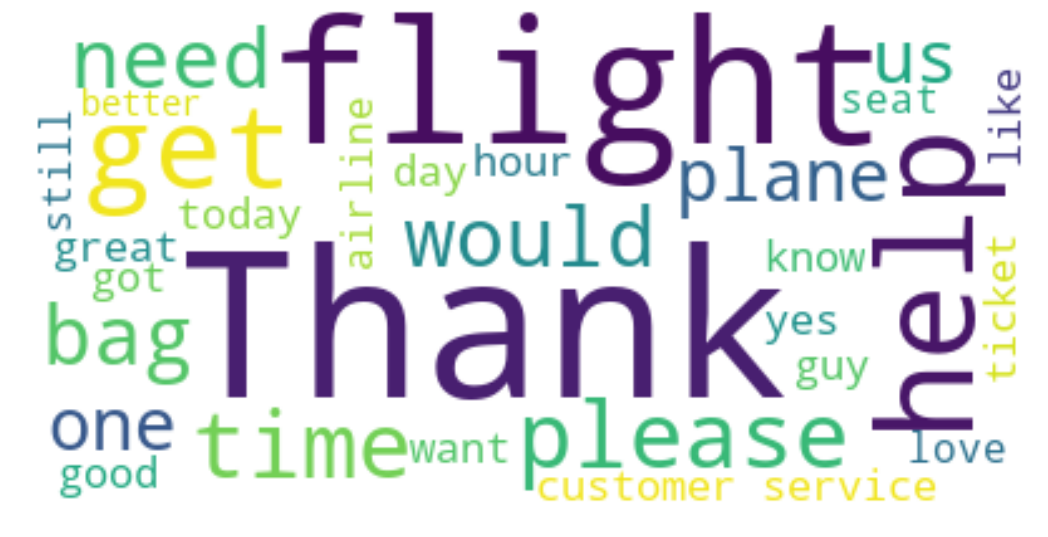

In [193]:
cloudstr = " ".join(tweet for tweet in data[data['polarity']=='positive']['text'])
wordcloud = WordCloud(background_color = "white", max_words=30, stopwords=custom_stopwords_pos).generate(cloudstr)

plt.figure(figsize=(18,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

## Customers were mostly talking about the above topics like "Thank", "Flight", "Help" and so on when they tweeted positively. The most frequent words used can also be seen below.

In [194]:
wordcloud.words_

{'Thank': 1.0,
 'flight': 0.7254313578394599,
 'help': 0.3765941485371343,
 'get': 0.2955738934733683,
 'please': 0.2145536384096024,
 'time': 0.21305326331582897,
 'would': 0.16729182295573894,
 'bag': 0.16654163540885222,
 'need': 0.16504126031507876,
 'plane': 0.16054013503375844,
 'us': 0.15978994748687173,
 'one': 0.15603900975243812,
 'customer service': 0.15153788447111777,
 'great': 0.1485371342835709,
 'like': 0.1417854463615904,
 'day': 0.13953488372093023,
 'hour': 0.13878469617404351,
 'yes': 0.13728432108027006,
 'today': 0.13728432108027006,
 'know': 0.13278319579894973,
 'want': 0.13278319579894973,
 'ticket': 0.1312828207051763,
 'guy': 0.1312828207051763,
 'good': 0.13053263315828958,
 'got': 0.13053263315828958,
 'love': 0.12003000750187547,
 'seat': 0.11852963240810202,
 'airline': 0.1177794448612153,
 'still': 0.11702925731432859,
 'better': 0.11177794448612154}

## But the single word frequency doesn't give much info about the topics. Let's print the most frequent bi-grams.

### Sentence tokenizing positive tweets

In [195]:
pos_sentences = []
pos_df = data[data['polarity']=='positive']
for i in range(0, pos_df.shape[0]):
    pos_sentences.extend(tweet for tweet in sent_tokenize(pos_df.iloc[i]['text']))
pos_sentences[:5]

['yes, nearly every time I fly VX this “ear worm” won’t go away :)',
 'Really missed a prime opportunity for Men Without Hats parody, there.',
 'it was amazing, and arrived an hour early.',
 "You're too good to me.",
 'I &lt;3 pretty graphics.']

### Word tokenizing each of the sentecnes & extracting bi-grams

In [196]:
bigram_pos = []
for line in pos_sentences:
    tokens = (word for word in word_tokenize(line) if word.lower() not in custom_stopwords_pos)
    bigram_pos.extend(ngrams(tokens, 2))

C:\Users\HPHP\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: generator 'ngrams' raised StopIteration
  after removing the cwd from sys.path.


In [197]:
fdist_pos = nltk.FreqDist(bigram_pos)
fdist_pos.most_common(20)

[(('customer', 'service'), 192),
 (('Cancelled', 'Flightled'), 130),
 (('Late', 'Flight'), 65),
 (('Late', 'Flightr'), 52),
 (('flight', 'Cancelled'), 51),
 (('Cancelled', 'Flighted'), 51),
 (('Booking', 'Problems'), 42),
 (('Cancelled', 'Flight'), 40),
 (('please', 'help'), 37),
 (('would', 'like'), 36),
 (('2', 'hours'), 34),
 (('looks', 'like'), 34),
 (('need', 'help'), 34),
 (('get', 'home'), 32),
 (('Please', 'help'), 32),
 (('first', 'class'), 28),
 (('change', 'flight'), 26),
 (('flight', 'attendant'), 26),
 (('Flightled', 'flight'), 25),
 (('great', 'flight'), 25)]

## We can see that above 2-word phrases occurred most frequently in positive tweets.

# Q3

### How many tweets mention each of the airlines?

Text(0.5,0,'Airlines')

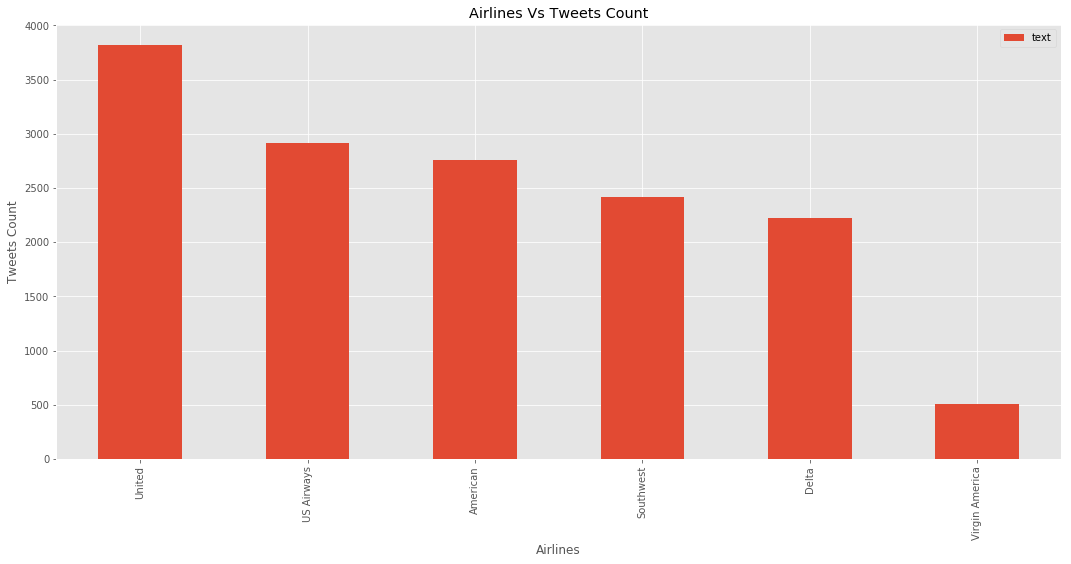

In [198]:
pd.DataFrame(data.groupby('airline')['text'].count().sort_values(ascending=False)).plot(kind='bar', figsize=(18,8), title='Airlines Vs Tweets Count')
plt.ylabel('Tweets Count')
plt.xlabel('Airlines')

#### United airlines was mentioned the most with 3822 number of tweets, whereas Virgin America was only referred 504 times.

### Which airline has most number of users tweeting about them?

Text(0.5,0,'Airlines')

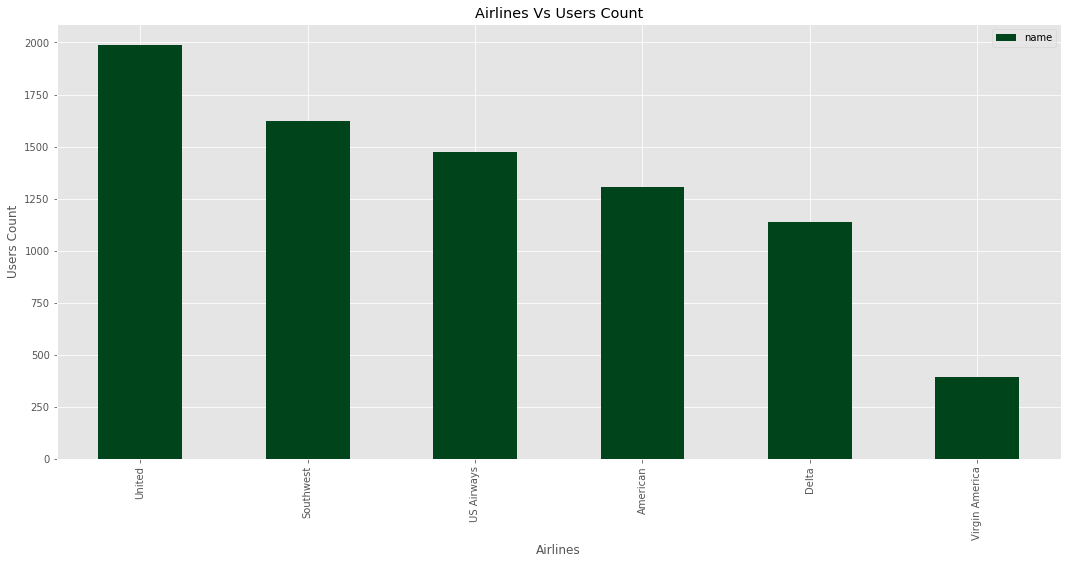

In [199]:
pd.DataFrame(data.groupby('airline')['name'].nunique().sort_values(ascending=False)).plot(kind='bar', figsize=(18,8), title='Airlines Vs Users Count', colormap='Greens_r')
plt.ylabel('Users Count')
plt.xlabel('Airlines')

#### Again, the same pattern follows for number of users here. While United Airlines is at top with 1989 unique users tweeting about them, Virgin America is at the bottom with 504 users tweeting about them. However, the middle order is completely different from above pattern.

## In which hours do users tweets most?

In [202]:
data['tweet_hour'] = pd.DatetimeIndex(data['tweet_created']).hour
data[['tweet_created','tweet_hour']].head()

,tweet_created,tweet_hour
0,2/24/2015 11:35,11
1,2/24/2015 11:15,11
2,2/24/2015 11:15,11
3,2/24/2015 11:15,11
4,2/24/2015 11:14,11


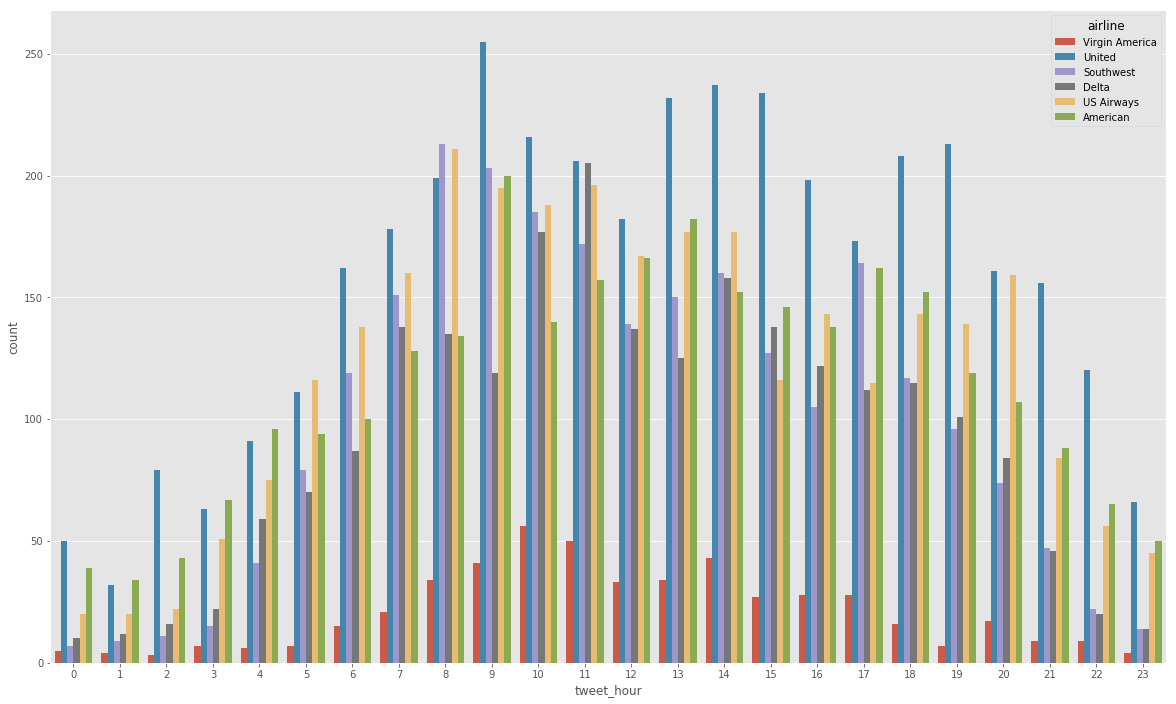

In [203]:
plt.figure(figsize=(20,12))
sns.countplot(data['tweet_hour'], hue=data['airline']);

### From above plot, it's obvious that most tweets are posted between 9 AM - 3 PM for majority of the airlines.

# Q4:

In [204]:
data_re = data[data['retweet_count']>0]
data_re.shape

(767, 19)

Text(0,0.5,'Tweets Count')

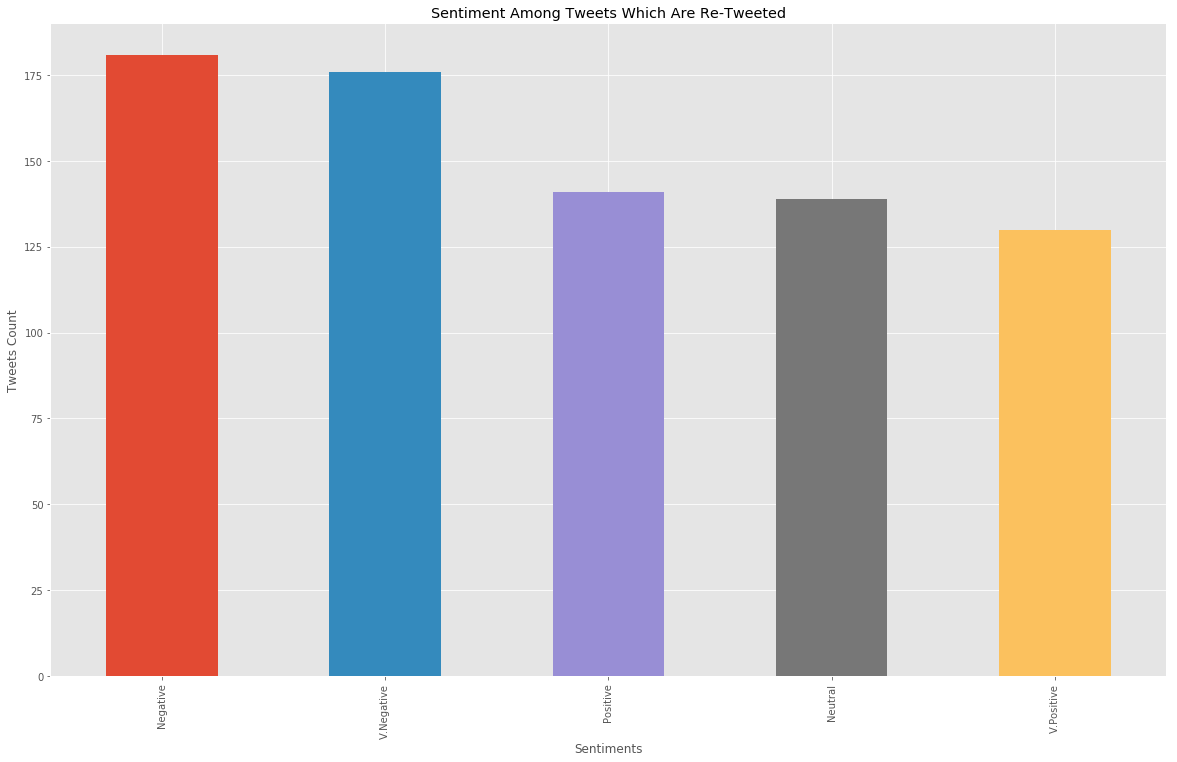

In [205]:
data_re.sentiment.value_counts().plot(kind='bar', title="Sentiment Among Tweets Which Are Re-Tweeted", figsize=(20,12))
plt.xlabel('Sentiments')
plt.ylabel('Tweets Count')

### So most tweets, which have re-tweets to them are Negative followed by Very Negative.

# Q5:

In [206]:
data_vp = data[data['sentiment']=='V.Positive']

In [207]:
pd.DataFrame(data_vp.groupby('name')['name'].count().sort_values(ascending=False))[:20]

,name
name,
Logunov_Daniil,10
geekstiel,9
kbosspotter,7
georgetietjen,7
MeeestarCoke,6
NoviceFlyer,6
chagaga2013,6
NickTypesWords,6
flemmingerin,5


### Above users are the top 20 users, who most frequently tweets very positively.

# Q6:

In [208]:
data_vn = data[data['sentiment']=='V.Negative']

In [209]:
pd.DataFrame(data_vn.groupby('name')['name'].count().sort_values(ascending=False))[:20]

,name
name,
Evan_Flay,7
Aero0729,7
idk_but_youtube,6
weezerandburnie,6
otisday,6
lj_verde,5
kevinforgoogle,5
ezemanalyst,5
GREATNESSEOA,5


### Above users are the top 20 users, who most frequently tweets very negatively.

# Bonus Questions

## BQ1:

In [213]:
np.mean(data.groupby('name')['airline'].nunique())

1.0283080119465005

### On average, a customer tweets about 1.03 number of airlines out of these 6 airlines.

## BQ2: This question can not be answered with the scope of the available dataset, since the data is from a range of only 9 days.

## BQ3:

### There is no column in the data to indicate if a tweet is in fact a re-tweet. So, I will consider all the tweets containing the string 'RT' in them as re-tweets and all other tweets as direct tweets.

In [225]:
" RT " in "Hello this TRT is test"

False

In [229]:
# Creating a dataframe with direct tweets count at user level
direct_tweets = data[~data['text'].str.contains(" RT ")][['name','text']].groupby('name').count()
direct_tweets.rename(columns={'text':'DTCount'},inplace=True)
direct_tweets.head()

,DTCount
name,
0504Traveller,5
0veranalyser,2
0xjared,1
10Eshaa,1
1234567890_,2


In [230]:
# Creating a dataframe with re-tweets count at user level
re_tweets = data[data['text'].str.contains(" RT ")][['name','text']].groupby('name').count()
re_tweets.rename(columns={'text':'RTCount'},inplace=True)
re_tweets.head()

,RTCount
name,
AbeFroman,1
AdamJEstep,1
AngBeTweetin,1
AritheGenius,1
BALLarsen,1


In [232]:
# Using inner join to get users who both tweeted and re-tweeted
tweets_df = pd.merge(direct_tweets, re_tweets, left_index=True, right_index=True,)
tweets_df

,DTCount,RTCount
name,,
BALLarsen,1,1
MOCBlogger,1,1
RyanEthanBeard,2,1
TheFireTracker2,1,1
bostongarden,6,1
danihampton,1,1
goodenufmother,3,1
mitchsunderland,5,1
vincenzolandino,6,1


In [233]:
tweets_df.shape

(10, 2)

### There are only 10 users who posted at least 1 tweet and 1 re-tweet

In [234]:
tweets_df.sort_values(by=['DTCount','RTCount'], ascending=False)

,DTCount,RTCount
name,,
bostongarden,6,1
vincenzolandino,6,1
mitchsunderland,5,1
goodenufmother,3,1
RyanEthanBeard,2,1
yourlocalnyer,2,1
BALLarsen,1,1
MOCBlogger,1,1
TheFireTracker2,1,1


### So, above are the users who most frequently tweeted & re-tweeted from top to bottom.